In [3]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Desktop/Classes/Research/deep_uncertainty/deep_uncertainty"))
from deep_uncertainty.evaluation.calibration import compute_mean_calibration, plot_regression_calibration_curve, display_bayes_credible_interval

# Bikes Data

Poisson

In [69]:
bikes = pd.read_csv('deep_uncertainty/data/bikes/hour.csv')
# bikes = bikes[:1000]

In [70]:
bikes = bikes.drop(['dteday', 'instant', 'registered'], axis=1)
X = bikes.iloc[:,:-1]
X = preprocessing.StandardScaler().fit_transform(X)
mask = np.random.rand(len(bikes)) < 0.8
df_train = bikes[mask]
df_test = bikes[~mask]

expr = "cnt ~ " + " + ".join(bikes.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [71]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[ 19.,  56.],
       [ 24.,  64.],
       [ 53., 108.],
       [ 46.,  98.],
       [ 41.,  91.],
       [ 19.,  55.],
       [ 21.,  59.],
       [ 22.,  61.],
       [ 27.,  68.],
       [ 30.,  74.]])

In [72]:
poisson_training_results.params

Intercept     3.404410
season        0.098715
yr            0.289982
mnth          0.006788
hr            0.040598
holiday       0.007363
weekday      -0.005990
workingday    0.506906
weathersit   -0.032532
temp         -0.110429
atemp         0.776292
hum          -0.321590
windspeed     0.232221
casual        0.007304
dtype: float64

In [73]:
y_test[:10].values

array([[  1.],
       [  8.],
       [110.],
       [ 67.],
       [ 37.],
       [ 17.],
       [  6.],
       [  3.],
       [  8.],
       [ 20.]])

In [74]:
mse = mean_squared_error(y_preds, y_test)
mse

16788.52866980368

In [75]:
np.sqrt(mse)

129.57055479468968

In [76]:
bikes['cnt'].mean()

189.46308763450142

In [77]:
bikes['cnt'].std()

181.38759909186527

In [78]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

KeyboardInterrupt: 

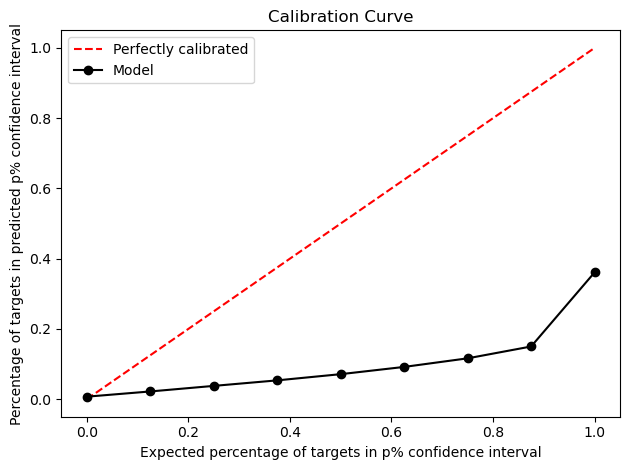

In [12]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [79]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_48925/4066697801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_48925/4066697801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_48925/4066697801.p

In [80]:
nb2_training_results.params

Intercept     2.959874
season        0.122840
yr            0.335876
mnth          0.002108
hr            0.052598
holiday      -0.000544
weekday       0.007031
workingday    0.562107
weathersit   -0.044585
temp         -0.449710
atemp         0.865668
hum          -0.174929
windspeed     0.277016
casual        0.011579
dtype: float64

In [83]:
y_preds = predicted_counts
y_test = y_test['cnt']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[  273., 12773.],
       [  308., 12383.],
       [  444., 11161.],
       [  415., 11392.],
       [  405., 11473.],
       [  250., 13054.],
       [  265., 12868.],
       [  273., 12769.],
       [  302., 12451.],
       [  316., 12293.]])

In [86]:
mse = mean_squared_error(y_preds, y_test)
mse

82832.74488982839

In [87]:
np.sqrt(mse)

287.8067839537984

In [88]:
y_test[:10].values

array([  1.,   8., 110.,  67.,  37.,  17.,   6.,   3.,   8.,  20.])

In [89]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

KeyboardInterrupt: 

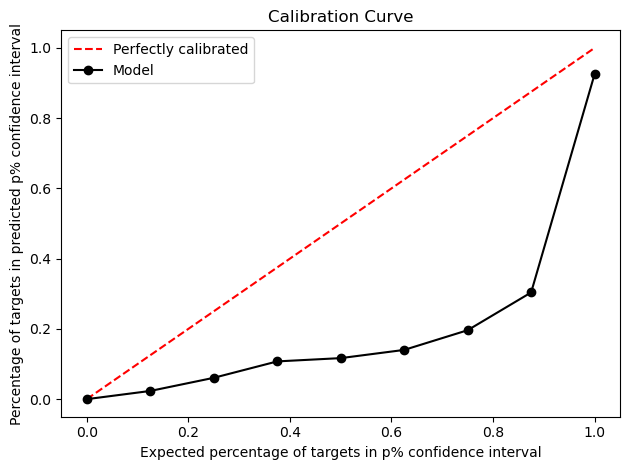

In [18]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

# Sales Data

Poisson

In [4]:
sales = pd.read_csv('deep_uncertainty/data/dominicks/cleaned_bath_counts.csv', low_memory=False)

In [5]:
sales = sales.drop(columns=['SALE', 'PRICE_HEX', 'PROFIT_HEX'], axis=1)
big_sales = sales.copy()
big_sales

,UPC,STORE,WEEK,QTY,PRICE,PROFIT,OK,NAME,CITY,ZIP,...,GROUP4,GROUP5,GROUP6,GROUP7,GROUP8,GROUP9,GROUP10,GROUP11,GROUP12,MOVE
0,5690310,70,348,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
1,5690310,70,349,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
2,5690310,70,350,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
3,5690310,70,351,1,2.5,14.48,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,1
4,5690310,70,352,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993364,78936105002,134,395,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0
14993365,78936105002,134,396,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0
14993366,78936105002,134,397,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0
14993367,78936105002,134,398,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0


In [6]:
med_sales = big_sales[:5000000]

In [7]:
sales = sales[:10000]

In [8]:
from sklearn.preprocessing import LabelEncoder

big_sales = big_sales.apply(LabelEncoder().fit_transform)
med_sales = med_sales.apply(LabelEncoder().fit_transform)

sales = sales.apply(LabelEncoder().fit_transform)
sales

,UPC,STORE,WEEK,QTY,PRICE,PROFIT,OK,NAME,CITY,ZIP,...,GROUP4,GROUP5,GROUP6,GROUP7,GROUP8,GROUP9,GROUP10,GROUP11,GROUP12,MOVE
0,0,0,164,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,165,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,166,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,167,0,34,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,168,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,107,0,119,0,18,602,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9996,107,0,120,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,107,0,121,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,107,0,122,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X = sales.iloc[:,:-1]
mask = np.random.rand(len(sales)) < 0.8
df_train = sales[mask]
df_test = sales[~mask]

expr = "MOVE ~ " + " + ".join(sales.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()

In [10]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
posterior_predictive
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 6.],
       [0., 2.],
       [0., 5.],
       [0., 5.],
       [0., 2.]])

In [13]:
poisson_training_results.params

Intercept   -2.367238e+01
UPC          9.075435e-03
STORE       -2.787797e-14
WEEK        -3.850094e-03
QTY          1.661634e-13
PRICE        1.910070e-02
PROFIT       3.068545e-03
OK           2.170788e+01
NAME         0.000000e+00
CITY         0.000000e+00
ZIP          0.000000e+00
LAT          0.000000e+00
LONG         0.000000e+00
SCLUSTER     0.000000e+00
ZONE         0.000000e+00
AGE9         0.000000e+00
AGE60        0.000000e+00
PRICLOW      0.000000e+00
PRICMED      0.000000e+00
PRICHIGH     0.000000e+00
GROUP1       0.000000e+00
GROUP2       0.000000e+00
GROUP3       0.000000e+00
GROUP4       0.000000e+00
GROUP5       0.000000e+00
GROUP6       0.000000e+00
GROUP7       0.000000e+00
GROUP8       0.000000e+00
GROUP9       0.000000e+00
GROUP10      0.000000e+00
GROUP11      0.000000e+00
GROUP12      0.000000e+00
dtype: float64

In [14]:
y_test[:10].values

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]])

In [15]:
print(y_preds)
len(y_preds)

[0.07226149 0.06377704 0.06349319 ... 0.23046423 0.26511366 0.21554851]


2001

In [16]:
mse = mean_squared_error(y_preds, y_test)
mse

0.8794251733136844

In [17]:
np.sqrt(mse)

0.9377767182617003

In [18]:
sales['MOVE'].mean()

0.4286

In [19]:
sales['MOVE'].std()

1.0372124280792185

In [32]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.634896472791657

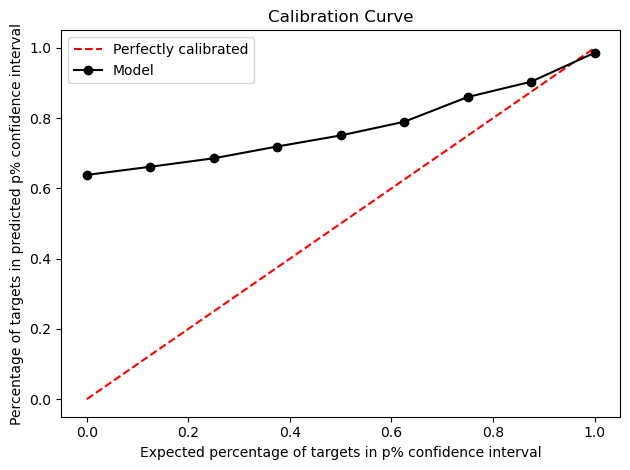

In [33]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [20]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['MOVE'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']


# Count number of successful predictions
# success_threshold = 1
# test_predictions = np.array(successes)
# y_test_values = y_test.values.flatten()
# absolute_differences = np.abs(test_predictions - y_test_values)
# successful_predictions_count = np.sum(absolute_differences <= success_threshold)
# print("Number of successful predictions:", successful_predictions_count)

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_1705/3737455413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_1705/3737455413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['MOVE'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_1705/3737455413.py:

In [21]:
y_preds = predicted_counts
y_test = y_test['MOVE']
# n is # of successes
n = successes
# p is the probability of success
p = n / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[   nan,    nan],
       [   nan,    nan],
       [   nan,    nan],
       [   nan,    nan],
       [   nan,    nan],
       [    0., 18320.],
       [   nan,    nan],
       [    0., 28685.],
       [    0., 31195.],
       [   nan,    nan]])

In [22]:
nb2_training_results.params

Intercept   -2.372427e+01
UPC          1.183440e-02
STORE        4.174360e-13
WEEK        -5.131228e-03
QTY         -6.698848e-14
PRICE        2.423082e-02
PROFIT       3.438211e-03
OK           2.153718e+01
NAME         0.000000e+00
CITY         0.000000e+00
ZIP          0.000000e+00
LAT          0.000000e+00
LONG         0.000000e+00
SCLUSTER     0.000000e+00
ZONE         0.000000e+00
AGE9         0.000000e+00
AGE60        0.000000e+00
PRICLOW      0.000000e+00
PRICMED      0.000000e+00
PRICHIGH     0.000000e+00
GROUP1       0.000000e+00
GROUP2       0.000000e+00
GROUP3       0.000000e+00
GROUP4       0.000000e+00
GROUP5       0.000000e+00
GROUP6       0.000000e+00
GROUP7       0.000000e+00
GROUP8       0.000000e+00
GROUP9       0.000000e+00
GROUP10      0.000000e+00
GROUP11      0.000000e+00
GROUP12      0.000000e+00
dtype: float64

In [23]:
y_test[:10].values

array([0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])

In [24]:
mse = mean_squared_error(y_preds, y_test)
mse

1.1492970885566827

In [26]:
np.sqrt(mse)

1.0720527452307012

In [39]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.36007413184848847

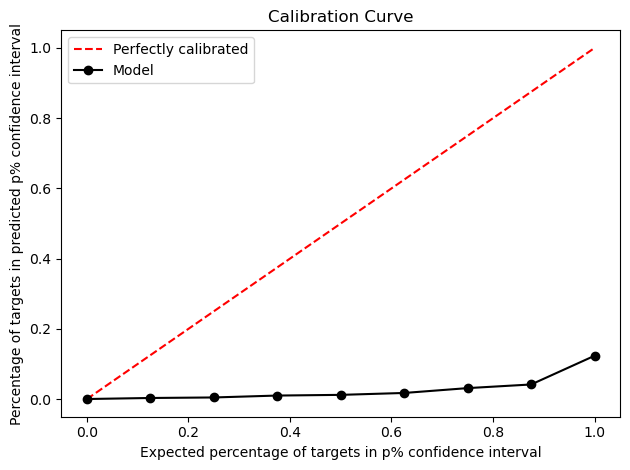

In [40]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

In [41]:
n

2      -3.037893
7      -3.061223
8      -3.065889
11     -3.098552
21     -3.145213
          ...   
9983   -1.537587
9989   -1.378634
9991    1.030155
9994    1.001610
9995    0.996944
Length: 2029, dtype: float64

In [42]:
p

2      -0.001497
7      -0.001509
8      -0.001511
11     -0.001527
21     -0.001550
          ...   
9983   -0.000758
9989   -0.000679
9991    0.000508
9994    0.000494
9995    0.000491
Length: 2029, dtype: float64

# COINS dataset